In [14]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from tqdm.auto import tqdm

# 2) Load data

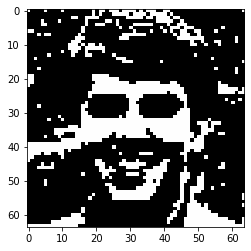

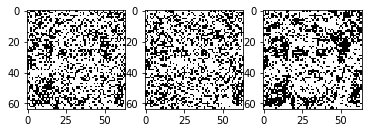

In [160]:
def draw_image(np_array):
    image = (np_array.reshape(64, 64) + 1) * 127
    img = Image.fromarray(image)
    plt.imshow(img)
    
def draw_images(arrays, title="", subtitles=None):
    for i in range(len(arrays)):
        plt.subplot(1, len(arrays), i + 1)
        if subtitles is not None:
            plt.title(subtitles[i])
        draw_image(arrays[i])
    if title != "":
        if len(arrays) > 1:
            plt.suptitle(title, y=0.82)
        else:
            plt.title(title)
    plt.show()
    
def load_image(img_path, threshold=130):
    img = Image.open(img_path)
    img.load()
    img = img.resize((64, 64))
    data = np.asarray(img, dtype="int32" )
    data = np.mean(data, axis=-1)  # RGB -> Grayscale
    data[data < threshold] = -1
    data[data >= threshold] = 1  # Bipolar
    data = data.flatten()
    return data

train, test = [], []
for i in range(1, 4, 1):
    test.append(load_image(f"Images_Q3/test{i}.png"))
train = load_image(f"Images_Q3/train.jpg").reshape(1, -1)
test = np.array(test)
draw_images(train)
draw_images(test)

# 3)

In [223]:
class HopfieldTrainer:
    def __init__(self, input_size: int, output_size: int, modified=False, threshold=0):
        self.weights = np.zeros((input_size, output_size))
        self.modified = modified
        self.threshold = threshold
        self.train_img = None

    def train(self, inputs, outputs):
        self.train_img = outputs.reshape(1, -1)
        for i, o in zip(inputs, outputs):
            i = i.reshape(1, -1)
            o = o.reshape(1, -1)
            self.weights += i.T @ o
        # Modification
        if self.modified:
            np.fill_diagonal(self.weights, 0)
    
    def predict(self, i, max_iter=2, log_steps=1000, save_images=True):
        i = i.reshape(1, -1)  # (1, 4096)
        plt.figure(figsize=(2, 2))
        draw_images(i, title="Input")
        y = np.copy(i)  # Set initial activations of net equal to the external input vector x
        history = {"y": [], "hamming_distance": []}
        for iteration in tqdm(range(max_iter)):
            print(f"### Iteration {iteration} ###")
            for enum, y_idx in enumerate(np.random.permutation(np.arange(i.shape[-1]))):
                y_in = i[0][y_idx] + np.dot(y[0], self.weights[:, y_idx])
                if y_in > self.threshold:
                    y[0][y_idx] = 1
                elif y_in < self.threshold:
                    y[0][y_idx] = -1
                if enum % log_steps == 0:
                    if save_images:
                        history["y"].append(np.copy(y))
                    history["hamming_distance"].append(self.hamming_distance(y[0], self.train_img[0]))
                    if history["hamming_distance"][-1] == 0:
                        break
            if history["hamming_distance"][-1] == 0:
                    break
        plt.figure(figsize=(16, 4))
        draw_images(history["y"], subtitles=[f"Hamming Dist: {h}" for h in np.round(history["hamming_distance"], 2)])
        return y, history
    
    def hamming_distance(self, a1, a2):
        return np.sum(a1 != a2) / len(a1)
    
    def draw_weights(self):
        mat = self.weights
        plt.matshow(mat, cmap=plt.cm.hot, fignum=False)
#         for (x, y), value in np.ndenumerate(mat.T):
#             plt.text(x, y, f"{value:.0f}", va="center", ha="center", color="green")

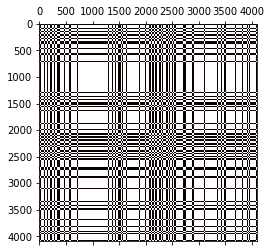

In [216]:
hofield = HopfieldTrainer(train.shape[1], train.shape[1], modified=False)
hofield.train(train, train)
hofield.draw_weights()

# 4)

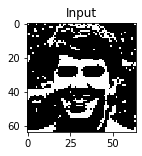

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###


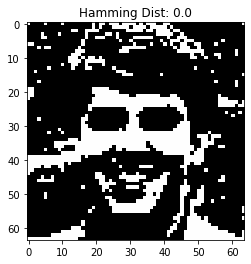

In [217]:
preds = [hofield.predict(d, log_steps=1) for d in train]
# draw_images(train, title="Inputs")
# draw_images(preds, title="Outputs")

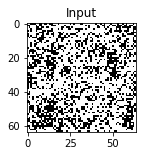

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###
### Iteration 1 ###


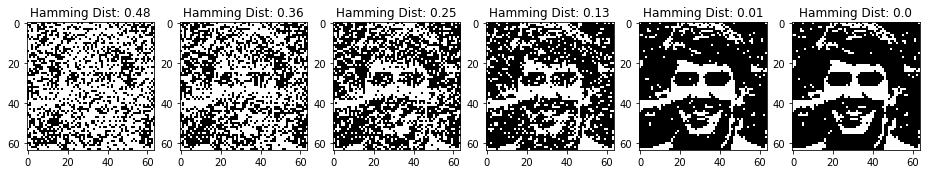

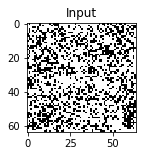

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###
### Iteration 1 ###


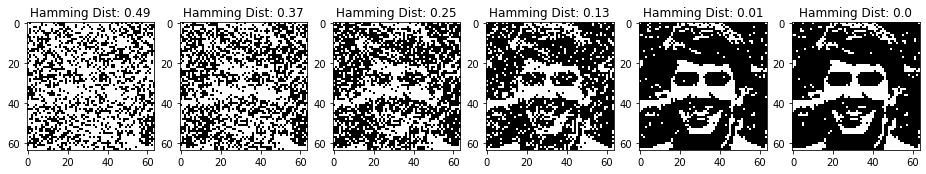

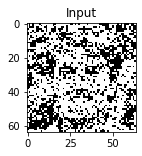

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###
### Iteration 1 ###


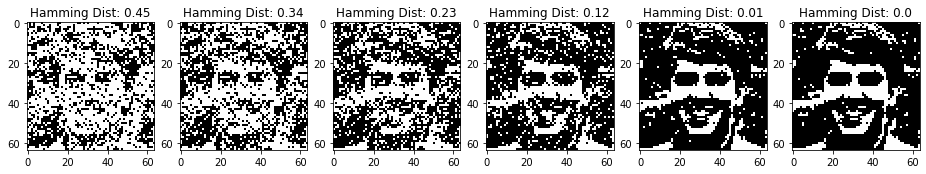

In [218]:
preds = [hofield.predict(d) for d in test]

# 5)

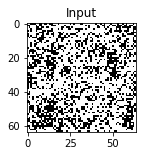

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###


<Figure size 1152x288 with 0 Axes>

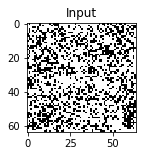

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###


<Figure size 1152x288 with 0 Axes>

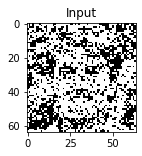

  0%|          | 0/2 [00:00<?, ?it/s]

### Iteration 0 ###


<Figure size 1152x288 with 0 Axes>

Text(0.5, 0, 'Unit update step')

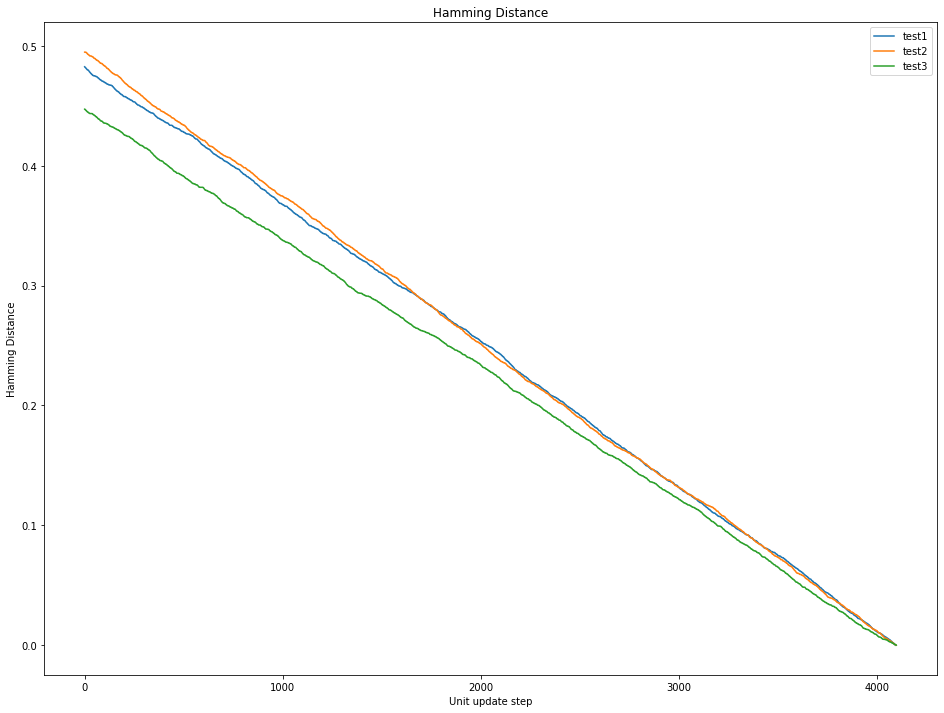

In [222]:
preds = [hofield.predict(d, log_steps=1, save_images=False) for d in test]
plt.figure(figsize=(16, 12))
for t in range(3):
    plt.plot(preds[t][1]["hamming_distance"], label=f"test{t + 1}")
plt.legend()
plt.title("Hamming Distance")
plt.ylabel("Hamming Distance")
plt.xlabel("Unit update step")